In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchmetrics import Accuracy
import requests
import zipfile
from pathlib import Path
import os
import random
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchinfo import summary
from typing import Dict, List

In [2]:
data_path = Path('data/')
image_path = data_path/ 'pizza_steak_sushi'

if image_path.is_dir():
    print(f'{image_path} directory already exists, skipping download')
else:
    print(f'{image_path} does not exists, creating one')
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip')
    print('Downloading Data')
    f.write(request.content)

# Unzip the file
with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
    print('Unzipping Data')
    zip_ref.extractall(image_path)

data\pizza_steak_sushi directory already exists, skipping download
Unzipping Data


In [3]:
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'There are {len(dirnames)} and {len(filenames)} images in {dirpath}')

In [4]:
walk_through_dir(image_path)

There are 2 and 0 images in data\pizza_steak_sushi
There are 3 and 0 images in data\pizza_steak_sushi\test
There are 1 and 25 images in data\pizza_steak_sushi\test\pizza
There are 0 and 3 images in data\pizza_steak_sushi\test\pizza\.ipynb_checkpoints
There are 0 and 19 images in data\pizza_steak_sushi\test\steak
There are 0 and 31 images in data\pizza_steak_sushi\test\sushi
There are 3 and 0 images in data\pizza_steak_sushi\train
There are 0 and 78 images in data\pizza_steak_sushi\train\pizza
There are 0 and 75 images in data\pizza_steak_sushi\train\steak
There are 0 and 72 images in data\pizza_steak_sushi\train\sushi


In [5]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

In [6]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

<font size="5" color='Orange'>Randomly Accessing an Image</font>

Random Image Path: data\pizza_steak_sushi\test\steak\296375.jpg
Image Class: steak
Image Height: 512
Image Width: 382


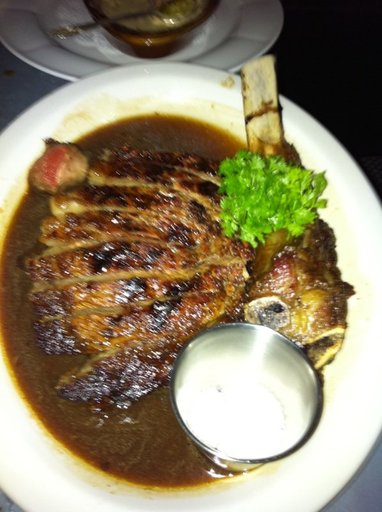

In [7]:
#random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# Pick a random image path
random_image_path = random.choice(image_path_list)

# Get Image Class from Path Name (The Image Class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# Loads the Image using PIL
img = Image.open(random_image_path)

print(f'Random Image Path: {random_image_path}')
print(f'Image Class: {image_class}')
print(f'Image Height: {img.height}')
print(f'Image Width: {img.width}')
img

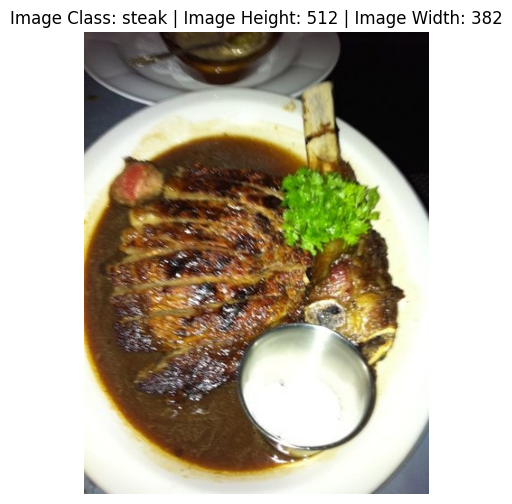

In [8]:
# Note: img is an image retreived from above cell
img_arr = np.asarray(img) # Converts the PIL image into a NumPy array (needed for visualization).
plt.figure(figsize=(10,6))
plt.imshow(img_arr)
plt.title(f'Image Class: {image_class} | Image Height: {img.height} | Image Width: {img.width}')
plt.axis(False)
plt.show()

<font size="6" color='pink'>Turning Images into Tensors</font>

<font size="4" color='yellow'>Transforming data with torchvision.transforms</font>

### Image Transformations in PyTorch
The following code applies:
- **Resizing**: Converts all images to 128x128 pixels.
- **Random Flip**: Flips images horizontally with a 50% chance.
- **Tensor Conversion**: Converts images into PyTorch tensors.

In [9]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [10]:
data_transform(img)

tensor([[[0.2902, 0.2941, 0.2824,  ..., 0.0392, 0.0471, 0.0431],
         [0.3059, 0.3020, 0.2902,  ..., 0.0431, 0.0431, 0.0392],
         [0.2941, 0.2784, 0.2627,  ..., 0.0431, 0.0471, 0.0431],
         ...,
         [0.4627, 0.4588, 0.4431,  ..., 0.3647, 0.3608, 0.3529],
         [0.4118, 0.4392, 0.4510,  ..., 0.3647, 0.3569, 0.3451],
         [0.3608, 0.4157, 0.4196,  ..., 0.3608, 0.3608, 0.3412]],

        [[0.2431, 0.2510, 0.2431,  ..., 0.0196, 0.0275, 0.0235],
         [0.2627, 0.2588, 0.2510,  ..., 0.0235, 0.0235, 0.0196],
         [0.2510, 0.2392, 0.2235,  ..., 0.0235, 0.0275, 0.0235],
         ...,
         [0.4824, 0.4745, 0.4549,  ..., 0.3882, 0.3843, 0.3804],
         [0.4275, 0.4627, 0.4824,  ..., 0.3882, 0.3804, 0.3725],
         [0.3725, 0.4471, 0.4667,  ..., 0.3843, 0.3843, 0.3725]],

        [[0.2392, 0.2471, 0.2392,  ..., 0.0353, 0.0431, 0.0392],
         [0.2471, 0.2510, 0.2471,  ..., 0.0392, 0.0392, 0.0353],
         [0.2392, 0.2314, 0.2275,  ..., 0.0392, 0.0431, 0.

In [11]:
def plot_transformed_images(image_paths:list, transform, n=3, seed=None):
    if seed:
        random.seed(seed)
    # This line selects 3 unique random images from image_paths without repetition.    
    random_image_paths = random.sample(image_paths, k=n)

    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f'Original \nSize: {f.size}')
            ax[0].axis(False)

            # Transform the image
            transformed_image = transform(f).permute(1,2,0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f'Transformed \nSize: {transformed_image.shape}')
            ax[1].axis(False)

            fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

In [12]:
image_path_list

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/309892.jp

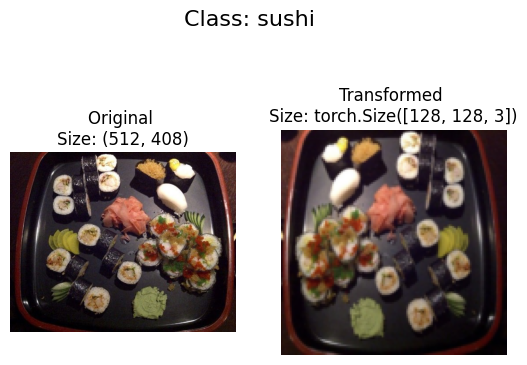

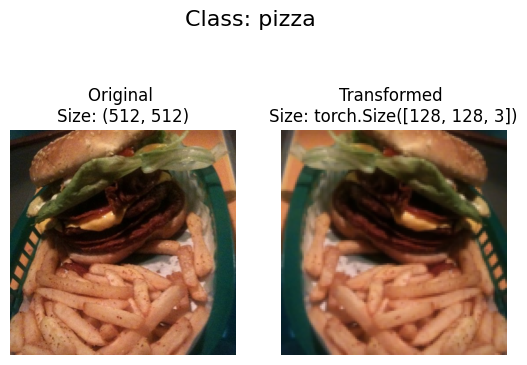

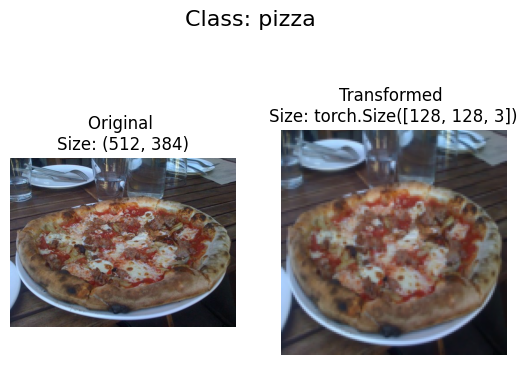

In [13]:
plot_transformed_images(image_paths=image_path_list, transform=data_transform, n=3, seed=42)

<font size="6" color='pink'>Loading Image data using ImageFolder</font>

In [14]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=data_transform,
    target_transform=None
)

In [15]:
test_data = datasets.ImageFolder(
    root=test_dir,  # Directory containing images organized in subfolders
    transform=data_transform,  # Image transformations (resize, flip, etc.)
    target_transform=None  # No transformation applied to labels
)

In [16]:
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 78
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
# Get class names as List
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [20]:
img, label = train_data[0][0], train_data[0][1]
print(f'Image Tensor: \n{img}')
print(f'Image Shape: {img.shape}')
print(f'Image Datatype: {img.dtype}')
print(f'Image Label: {label}')
print(f'Label Datatype: {type(label)}')

Image Tensor: 
tensor([[[0.1137, 0.1137, 0.1059,  ..., 0.1098, 0.1098, 0.1137],
         [0.1137, 0.1098, 0.1059,  ..., 0.1216, 0.1216, 0.1255],
         [0.1098, 0.1059, 0.1020,  ..., 0.1294, 0.1294, 0.1333],
         ...,
         [0.0824, 0.0863, 0.0902,  ..., 0.1647, 0.1686, 0.1765],
         [0.0902, 0.0863, 0.0824,  ..., 0.1647, 0.1686, 0.1765],
         [0.0863, 0.0824, 0.0824,  ..., 0.1569, 0.1569, 0.1608]],

        [[0.0706, 0.0745, 0.0706,  ..., 0.0549, 0.0549, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0745,  ..., 0.0627, 0.0627, 0.0667],
         ...,
         [0.1059, 0.1098, 0.1098,  ..., 0.2275, 0.2275, 0.2314],
         [0.1059, 0.1020, 0.1020,  ..., 0.2275, 0.2314, 0.2314],
         [0.1020, 0.0980, 0.0980,  ..., 0.2353, 0.2275, 0.2275]],

        [[0.0941, 0.0980, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0941, 0.0941, 0.0902,  ..., 0.0235, 0.0235, 0.0235],
         [0.0941, 0.0941, 0.0902,  ..., 0.0

In [21]:
class_names[label]

'pizza'

<font size="5" color='red'>Note: Matplotlib requires Color_Channels(CC) in the end, so permute the image</font>

In [22]:
permuted_img = img.permute(1,2,0)

# Compare the shapes
print(f'Original Shape: {img.shape}  -> [CC, Height, Width]')
print(f'Permuted Shape: {permuted_img.shape}  -> [Height, Width, CC]')

Original Shape: torch.Size([3, 128, 128])  -> [CC, Height, Width]
Permuted Shape: torch.Size([128, 128, 3])  -> [Height, Width, CC]


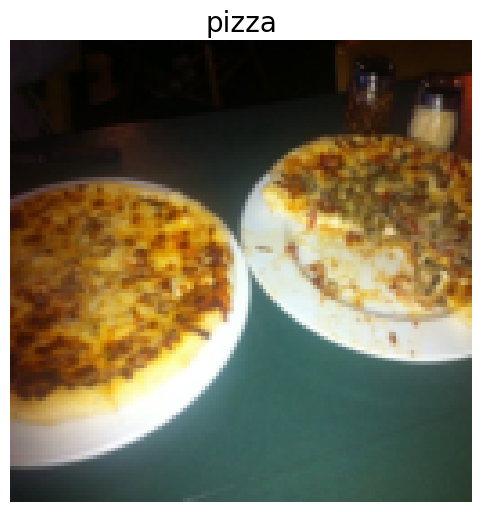

In [23]:
# Plot the image
plt.figure(figsize=(10,6))
plt.imshow(permuted_img)
plt.title(class_names[label], fontsize=20)
plt.axis(False)
plt.show()

<font size="6" color='pink'>Dataloader</font>

# ✅ DataLoader handles batching, shuffling, and parallel processing.

In [24]:
workers = os.cpu_count()
workers

8

In [25]:
BATCH_SIZE = 32

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

In [26]:
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x1e662b81e80>,
 <torch.utils.data.dataloader.DataLoader at 0x1e666feead0>)

In [27]:
len(train_loader), len(test_loader)

(8, 3)

In [28]:
len(train_data), len(test_data)

(225, 78)

In [29]:
img, label = next(iter(train_loader))

print(f'Image Shape: {img.shape}  -> [batch_size, color_channels, height, width]')
print(f'Label Shape: {label.shape}')

Image Shape: torch.Size([32, 3, 128, 128])  -> [batch_size, color_channels, height, width]
Label Shape: torch.Size([32])


<font size="5" color='Orange'>Data Augmentation</font>

## Other forms of transforms (data augmentation)

Data Augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.
For ex- looking at the image but from different perspectives. like original, rotate, shift, zoom

In [30]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [31]:
image_path

WindowsPath('data/pizza_steak_sushi')

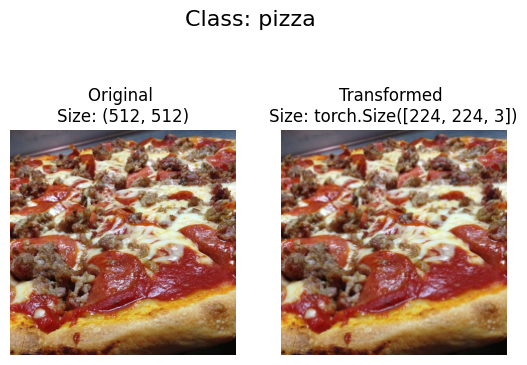

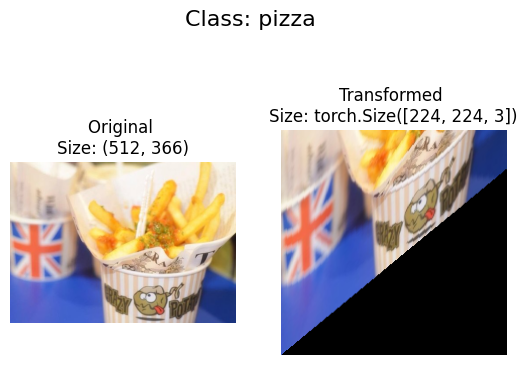

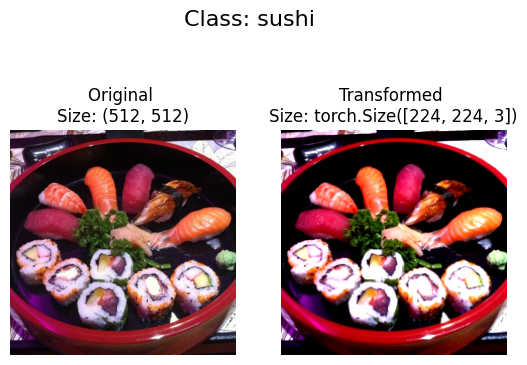

In [32]:
image_path_list = list(image_path.glob('*/*/*.jpg'))

plot_transformed_images(image_paths=image_path_list, transform=train_transform, n=3, seed=None)

# Model 0: TinyVGG without Data Augmentation

In [33]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

<font size="4" color='yellow'>Loading Image data using ImageFolder</font>

In [34]:
train_data = datasets.ImageFolder(
    root=train_dir,
    transform=simple_transform
)

test_data = datasets.ImageFolder(
    root=test_dir,
    transform=simple_transform
)

<font size="4" color='yellow'>Turn the Dataset into Dataloader</font>

In [35]:
workers = os.cpu_count()
workers

8

In [36]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

In [37]:
len(train_data), len(test_data)

(225, 78)

In [38]:
len(train_dataloader), len(test_dataloader)

(8, 3)

<font size="4" color='yellow'>Create TinyVGG model class</font>

In [39]:
class Model(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_network1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)

        ) 

        self.conv_network2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0
                     ),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                     out_channels=hidden_units,
                     kernel_size=3,
                     stride=1,
                     padding=0
                     ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                     out_features=output_shape)
        )

    def forward(self, x):
        # x =  self.conv_network1(x)
        # print(x.shape)
        # x =  self.conv_network2(x)
        # print(x.shape)
        # x =  self.classifier(x)
        # print(x.shape)
        # return x
        return self.classifier(self.conv_network2(self.conv_network1(x))) # This way is preferrable

In [40]:
torch.manual_seed(42)
model_0 = Model(
    input_shape=3,# No. of Color Channels
    hidden_units=10,
    output_shape=len(class_names)
)
model_0

Model(
  (conv_network1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_network2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

<font size="4" color='yellow'>Trying a forward pass on a single image (to test the model)</font>

In [41]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [42]:
# Try a forward pass
model_0(image_batch)

''' This will give an error of RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3) (in case if i restart the kernel) '''

' This will give an error of RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3) (in case if i restart the kernel) '

**Note:**  
`RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)`  
Try multiplying the last 2 numbers of `torch.Size([32, 10, 13, 13])` into hidden units.  
For Example:  
`nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)`


In [43]:
# Try a forward pass again
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4989e-03],
        [ 2.2101e-02, -4.1470e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2934e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

<font size="5" color='Orange'>Torch Info</font>

In [44]:
summary(model_0, input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

<font size="4" color='yellow'>Training and Testing Loop</font>

In [45]:
# Important Parameters
learning_rate = 0.001
epochs = 5

In [46]:
# Loss Function and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

**Creating a Training Method**

In [47]:
def train_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              optimizer:torch.optim.Optimizer,
              accuracy):
    train_loss, train_acc = 0,0
    model.train()

    # Add a loop through the training batch
    for batch, (X,y) in enumerate(dataloader):
        # Forward Pass (outputs the raw logits from the model)
        y_pred = model(X)

        # Calculate Loss and Accuracy per batch
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy(y, y_pred.argmax(dim=1)).item()*100 
        
        # Set Gradients to zero
        optimizer.zero_grad()
        
        # BackPropogation
        loss.backward()

        # Update the Parameters
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

**Creating a Testing Method**

In [48]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_function:torch.nn.Module,
              accuracy):
    test_loss, test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        # Add a loop through the testing batch
        for batch, (X,y) in enumerate(dataloader):
            # Forward Pass (outputs the raw logits from the model)
            test_pred = model(X)
    
            # Calcualte Loss and Accuracy per batch
            loss = loss_function(test_pred, y)
            test_loss += loss.item()
            test_acc += accuracy(y, test_pred.argmax(dim=1)).item()*100

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        return test_loss, test_acc

<font size="4" color='yellow'>Creating a train() function to combine train_step() and test_step()</font>

In [49]:
def train(model: torch.nn.Module,
         train_dataloader:torch.utils.data.DataLoader,
         test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_function: torch.nn.Module,
          accuracy,
          epochs:int = 5):
   
    # Create empty result dictionary
    results = {'train_loss':[],
              'train_acc':[],
              'test_loss':[],
              'test_acc':[]}
    
    # Loop through training and testing steps for the number of epochs
    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_function=loss_function,
                                          optimizer=optimizer,
                                          accuracy=accuracy)

        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_function=loss_function,
                                       accuracy=accuracy)
       
        print(f"Training Loss: {train_loss:.5f} | Training Accuracy: {train_acc:.2f} | Testing Loss: {test_loss:.5f} | Testing Accuracy: {test_acc:.2f}%")

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['test_loss'].append(test_loss)
        results['test_acc'].append(test_acc)

    return results

In [50]:
torch.manual_seed(42)

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

model_0_results = train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_function=loss_function,
                        accuracy=accuracy,
                       epochs=5)

Training Loss: 1.10354 | Training Accuracy: 25.00 | Testing Loss: 1.09436 | Testing Accuracy: 38.54%
Training Loss: 1.07675 | Training Accuracy: 42.58 | Testing Loss: 1.10223 | Testing Accuracy: 35.86%
Training Loss: 1.12914 | Training Accuracy: 30.47 | Testing Loss: 1.09877 | Testing Accuracy: 35.86%
Training Loss: 1.07853 | Training Accuracy: 42.58 | Testing Loss: 1.08813 | Testing Accuracy: 36.90%
Training Loss: 1.09312 | Training Accuracy: 32.42 | Testing Loss: 1.07560 | Testing Accuracy: 38.39%


In [51]:
model_0_results

{'train_loss': [1.1035432368516922,
  1.0767481699585915,
  1.129138544201851,
  1.078527756035328,
  1.0931153297424316],
 'train_acc': [25.0, 42.578125, 30.46875, 42.578125, 32.421875],
 'test_loss': [1.0943612257639568,
  1.1022271315256755,
  1.098765254020691,
  1.0881263415018718,
  1.0755982796351116],
 'test_acc': [38.541666666666664,
  35.86309552192688,
  35.86309552192688,
  36.904762188593544,
  38.392857213815056]}

<font size="6" color='pink'>Loss Curves of Model 0</font>

**Loss Curves is a way of tracking the model's progress over time.**

In [52]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [53]:
def plot_loss_curves(results:Dict[str, List[float]]):
    # Get the loss values
    train_loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the loss values
    train_acc = results['train_acc']
    test_acc = results['test_acc']

    # Figure out the Number of epochs
    epochs = range(len(results['train_loss']))

    # Setup the Plot
    plt.figure(figsize=(15,7))

    # Plot the Loss
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label='train loss')
    plt.plot(epochs,test_loss,label='test loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot the Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs,train_acc,label='train accuracy')
    plt.plot(epochs,test_acc,label='test accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

<font size="5" color='Orange'>For an Efficient Model, ''loss curves must go down'', ''and accuracy curves must go up''</font>

***Check this link:- https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves***

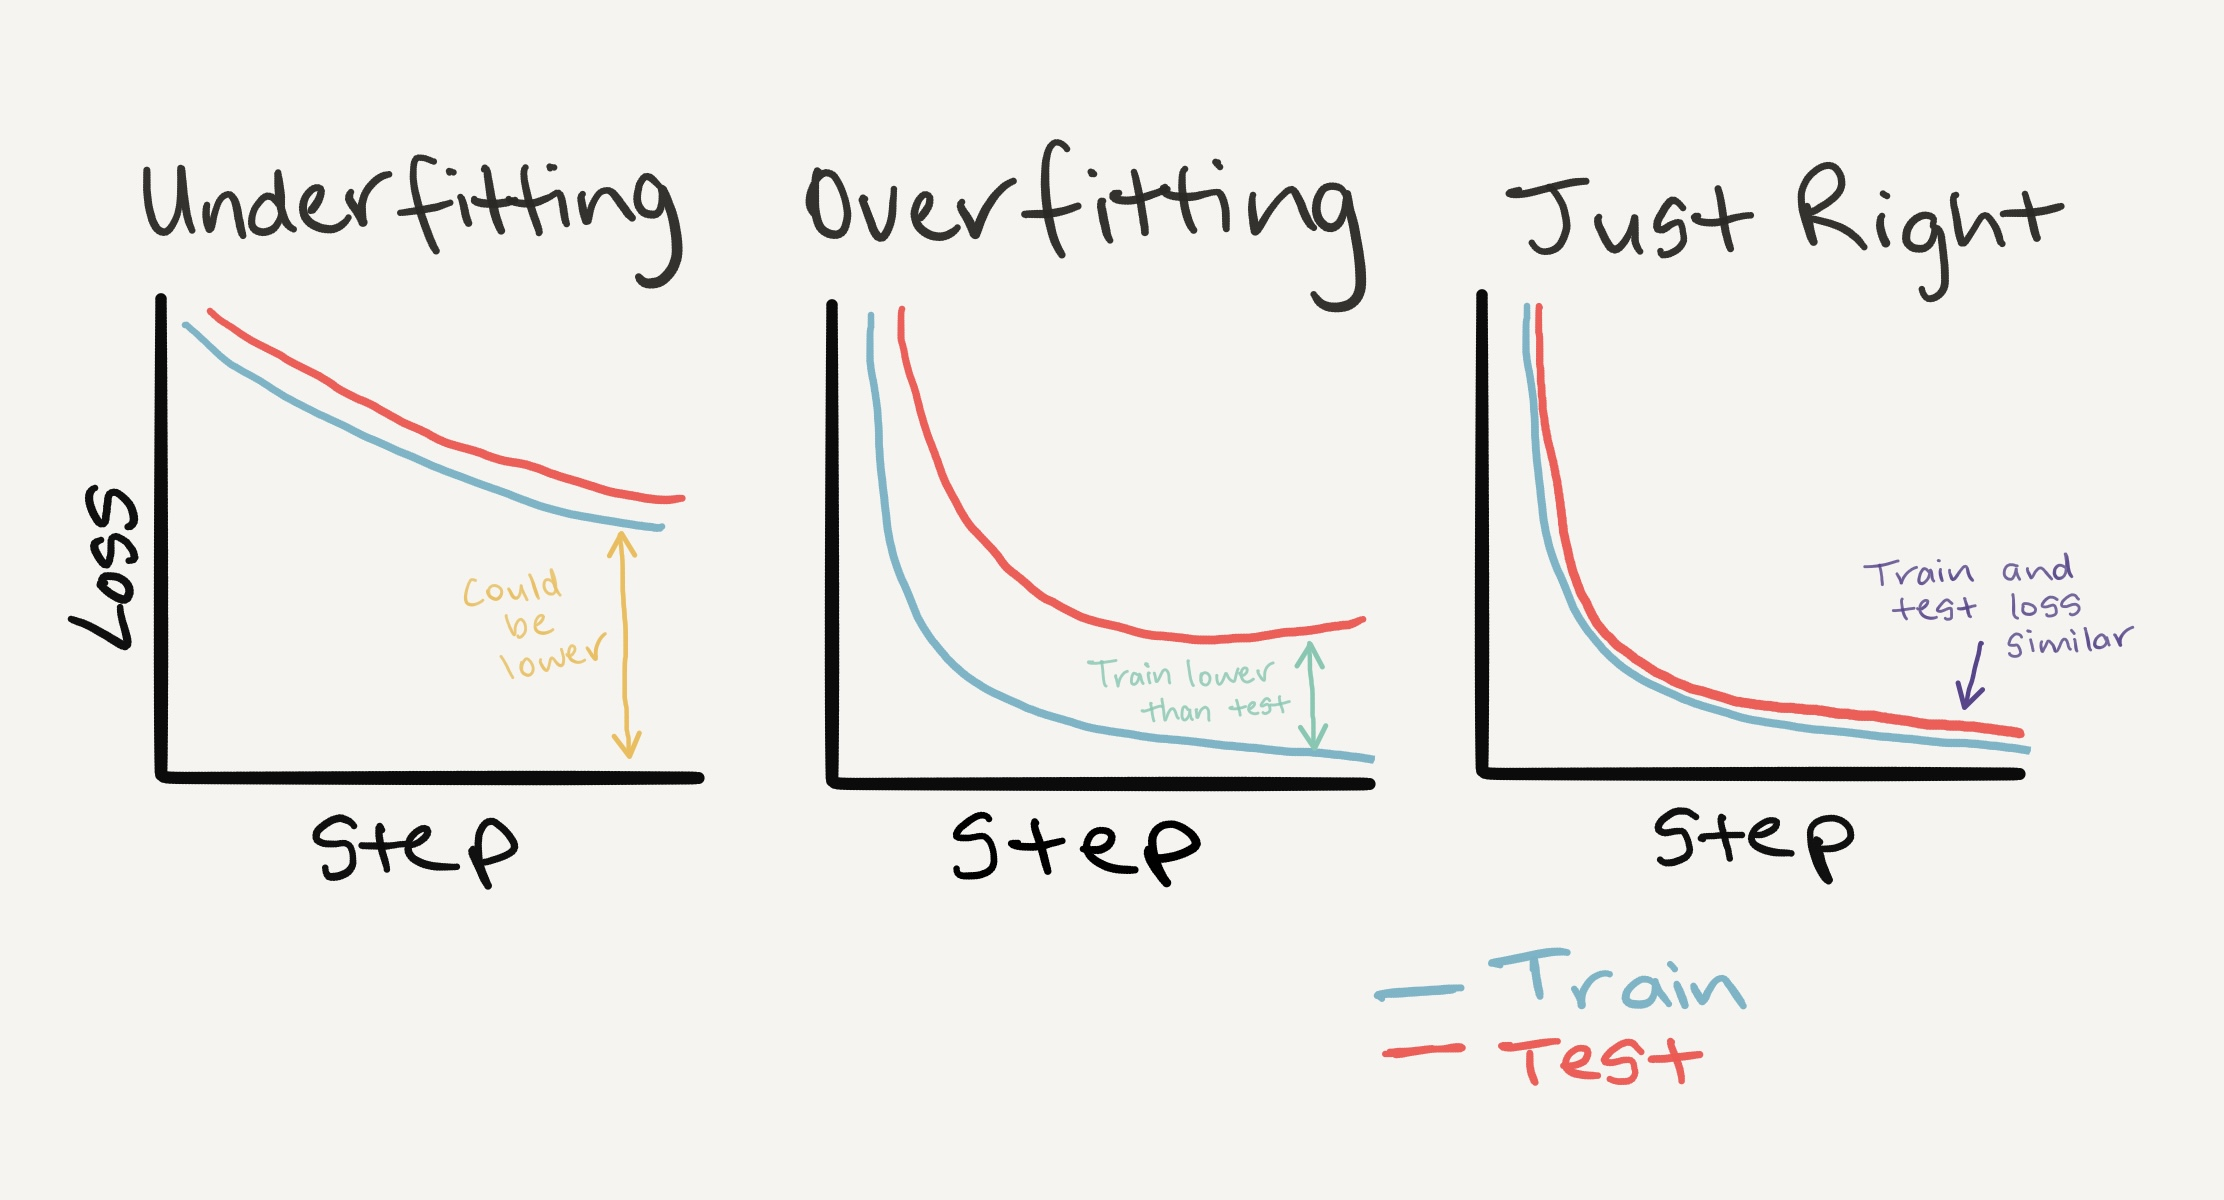

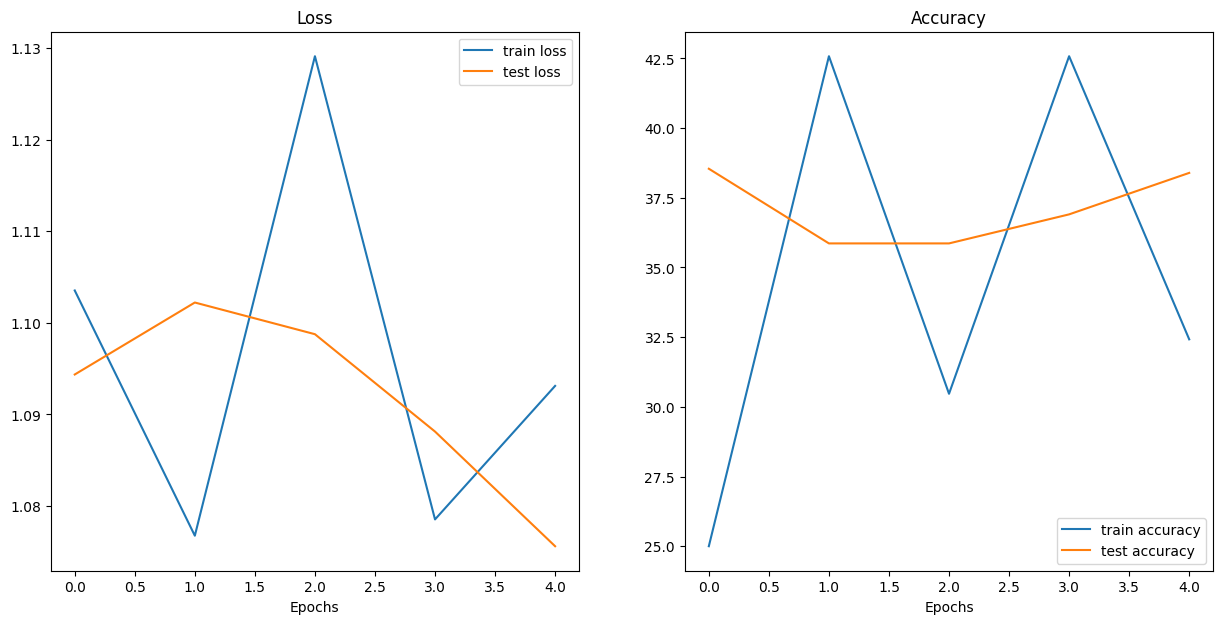

In [54]:
plot_loss_curves(model_0_results)

# Model 1: TinyVGG with Data Augmentation

In [55]:
print(img.size())

torch.Size([32, 3, 128, 128])


In [56]:
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.ToTensor()
])

<font size="4" color='yellow'>Loading Image data using ImageFolder</font>

In [57]:
train_data_augmented = datasets.ImageFolder(
    root=train_dir,
    transform=train_transform_trivial
)

test_data_augmented = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform_simple
)

<font size="4" color='yellow'>Turn Datasets into DataLoader</font>

In [58]:
workers = os.cpu_count()
workers

8

In [59]:
torch.manual_seed(42)

BATCH_SIZE = 32

train_dataloader_augmented = DataLoader(dataset=train_data_augmented, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

test_dataloader_augmented = DataLoader(dataset=test_data_augmented, batch_size=BATCH_SIZE, num_workers=workers, shuffle=True)

In [60]:
len(train_data_augmented), len(test_data_augmented)

(225, 78)

In [61]:
len(train_dataloader_augmented), len(test_dataloader_augmented)

(8, 3)

<font size="4" color='yellow'>Create TinyVGG model class</font>

In [65]:
torch.manual_seed(42)
model_1 = Model(
    input_shape=3,# No. of Color Channels
    hidden_units=10,
    output_shape=len(class_names)
)
model_1

Model(
  (conv_network1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_network2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [66]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_augmented))
image_batch.shape

torch.Size([32, 3, 128, 128])

In [64]:
model_1(image_batch)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (8410x841 and 1421290x3)

In [ ]:
# Loss Function and Optimizer
loss_function_augmented = nn.CrossEntropyLoss()
optimizer_augmented = torch.optim.Adam(model_0.parameters(), lr=0.01)

In [ ]:
torch.manual_seed(42)

accuracy = Accuracy(task="multiclass", num_classes=len(class_names))

model_1_results = train(model=model_1,
                       train_dataloader=train_dataloader_augmented,
                       test_dataloader=test_dataloader_augmented,
                       optimizer=optimizer_augmented,
                       loss_function=loss_function_augmented,
                        accuracy=accuracy,
                       epochs=5)

<font size="6" color='pink'>Loss Curves of Model 1</font>

In [ ]:
plot_loss_curves(model_1_results)

In [ ]:
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

In [ ]:
model_1_df

<font size="6" color='pink'>Comparsion using Visualization</font>

In [ ]:
plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df['test_loss'], label='Model 0')
plt.plot(epochs, model_1_df['test_loss'], label='Model 1')
plt.title('Testing Loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df['train_acc'], label='Model 0')
plt.plot(epochs, model_1_df['train_acc'], label='Model 1')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df['test_acc'], label='Model 0')
plt.plot(epochs, model_1_df['test_acc'], label='Model 1')
plt.title('Testing Accuracy')
plt.xlabel('Epochs')
plt.legend()

<font size="6" color='pink'>Uploading Image which is not in data, to test the accuracy of our model</font>

In [ ]:
custom_image_path = data_path/ '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true')
        print('Downloading Data')
        f.write(request.content)
else:
    print(f'{custom_image_path} directory already exists, skipping download')

In [ ]:
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f'Image Tensor: {custom_image_uint8}\n')
print(f'Image Shape: {custom_image_uint8.shape}')
print(f'Image Datatype: {custom_image_uint8.dtype}')

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [ ]:
# Convert int Tensor to float Tensor
custom_image = custom_image_uint8.type(torch.float32) / 255
custom_image

In [ ]:
plt.imshow(custom_image_uint8.permute(1,2,0))

In [ ]:
custom_image_transform = transforms.Compose([
    transforms.Resize(size=(64,64))
])

In [ ]:
custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed

In [ ]:
print(f'Image Tensor: {custom_image_transformed}\n')
print(f'Image Shape: {custom_image_transformed.shape}')
print(f'Image Datatype: {custom_image_transformed.dtype}')

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))

custom_image_pred    

In [ ]:
# Convert raw logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

In [ ]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

In [ ]:
class_names[custom_image_pred_label]

<font size="6" color='pink'>Putting custom image prediction together: Building a Function</font>

In [ ]:
def pred_and_plot_image(model:torch.nn.Module,
                       image_path:str,
                       class_names:List[str] = None,
                       transform=None):
    # Load the Image
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide the image pixels by value 255 to range them between 0 and 1
    target_image = target_image / 255.

    # Transform if necessary
    if transform:
        target_image = transform(target_image)

    # Turn on eval mode/inference mode to make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension  (this is the batch dimension)
        target_image =target_image.unsqueeze(0)

        # Make Prediction
        target_image_pred = model(target_image)

    # Convert raw logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the Image
    plt.imshow(target_image.squeeze().permute(1,2,0)) # remove batch dimension and rearrange the shape

    if class_names:
        title = f'Prediction: {class_names[target_image_pred_label]} | Probability {target_image_pred_probs.max():.3f}'
    else:
        title = f'Prediction: {target_image_pred_label} | Probability {target_image_pred_probs.max():.3f}'
    plt.title(title)
    plt.axis(False)

In [ ]:
pred_and_plot_image(model=model_1,
                   image_path=custom_image_path,
                   class_names=class_names,
                   transform=custom_image_transform)